In [3]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
nx = 9
ny = 6

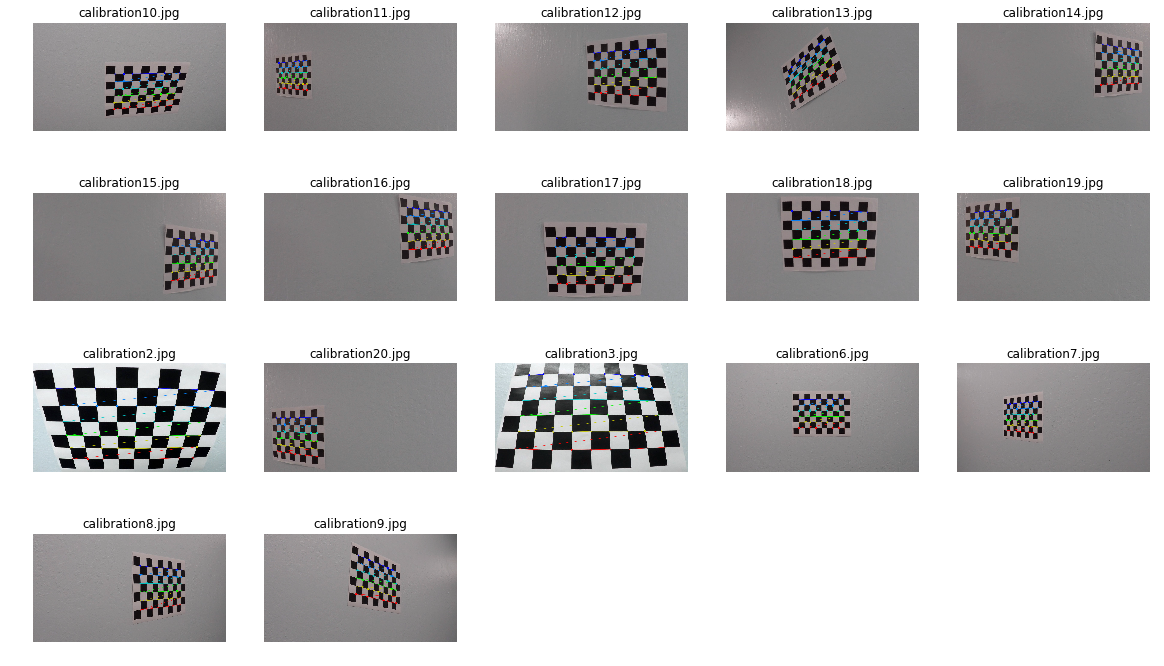

Used 17 images for camera calibration.


In [5]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

fig_count = len(images)
cols = 5
rows = int(fig_count/cols)

plt.figure(figsize=(20, 12))
idx = 1
for fname in sorted(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        plt.subplot(rows, cols, idx)
        plt.axis('off')
        plt.title(fname.split('/')[-1])
        plt.imshow(img)
        idx += 1

plt.savefig('output_images/chessboard_corners.jpg')
plt.show()

print("Used {} images for camera calibration.".format(idx-1))

In [6]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

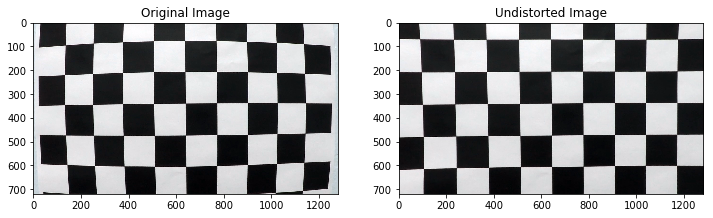

In [7]:
img = cv2.imread('camera_cal/calibration1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.title('Undistorted Image')
plt.imshow(dst)

plt.savefig('output_images/undistorted.jpg')
plt.show()

([], <a list of 0 Text yticklabel objects>)

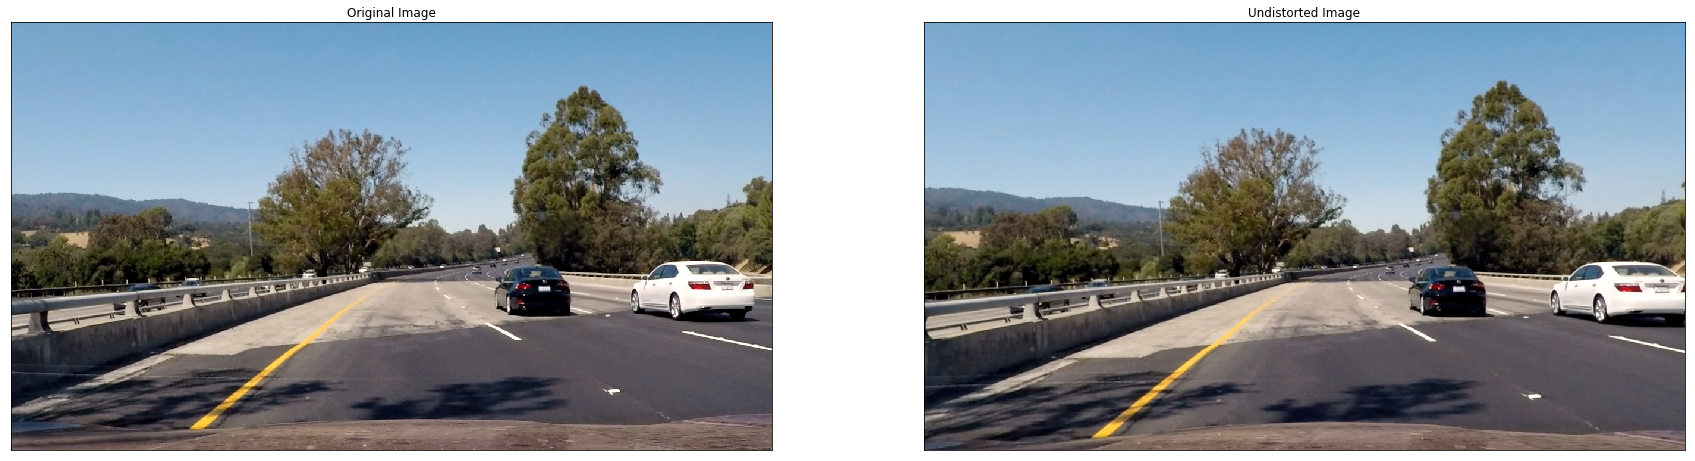

In [8]:
test_image = cv2.cvtColor(cv2.imread('test_images/test4.jpg'),cv2.COLOR_BGR2RGB)
undistorted_img = cv2.undistort(test_image, mtx, dist, None, mtx)


plt.figure(figsize=(30,50))
plt.subplot(121)
plt.imshow(test_image)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(undistorted_img)
plt.title('Undistorted Image')
plt.xticks([])
plt.yticks([])

In [46]:
## Thresholding

def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    max_value = np.max(abs_sobel)
    binary_output = np.uint8(255*abs_sobel/max_value)
    threshold_mask = np.zeros_like(binary_output)
    threshold_mask[(binary_output >= thresh_min) & (binary_output <= thresh_max)] = 1
    return threshold_mask

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobel_y,abs_sobel_x)
    direction = np.absolute(direction)
    # 5) Create a binary mask where direction thresholds are met
    mask = np.zeros_like(direction)
    mask[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mask


def get_thresholded_image(img):
    
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    height, width = gray.shape
    
    # apply gradient threshold on the horizontal gradient
    sx_binary = abs_sobel_thresh(gray, 'x', 10, 200)
    
    # apply gradient direction threshold so that only edges closer to vertical are detected.
    dir_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    
    # combine the gradient and direction thresholds.
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    
    # color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    # S channel performs well for detecting bright yellow and white lanes
    s_thresh = (100, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    
    # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.
    l_thresh = (80, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])

    # combine all the thresholds
    # A pixel should either be a yellowish or whiteish
    # And it should also have a gradient, as per our thresholds
    color_combined[(r_g_condition & l_condition) & (s_condition | combined_condition)] = 1
    
    # apply the region of interest mask
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)
    
    return thresholded

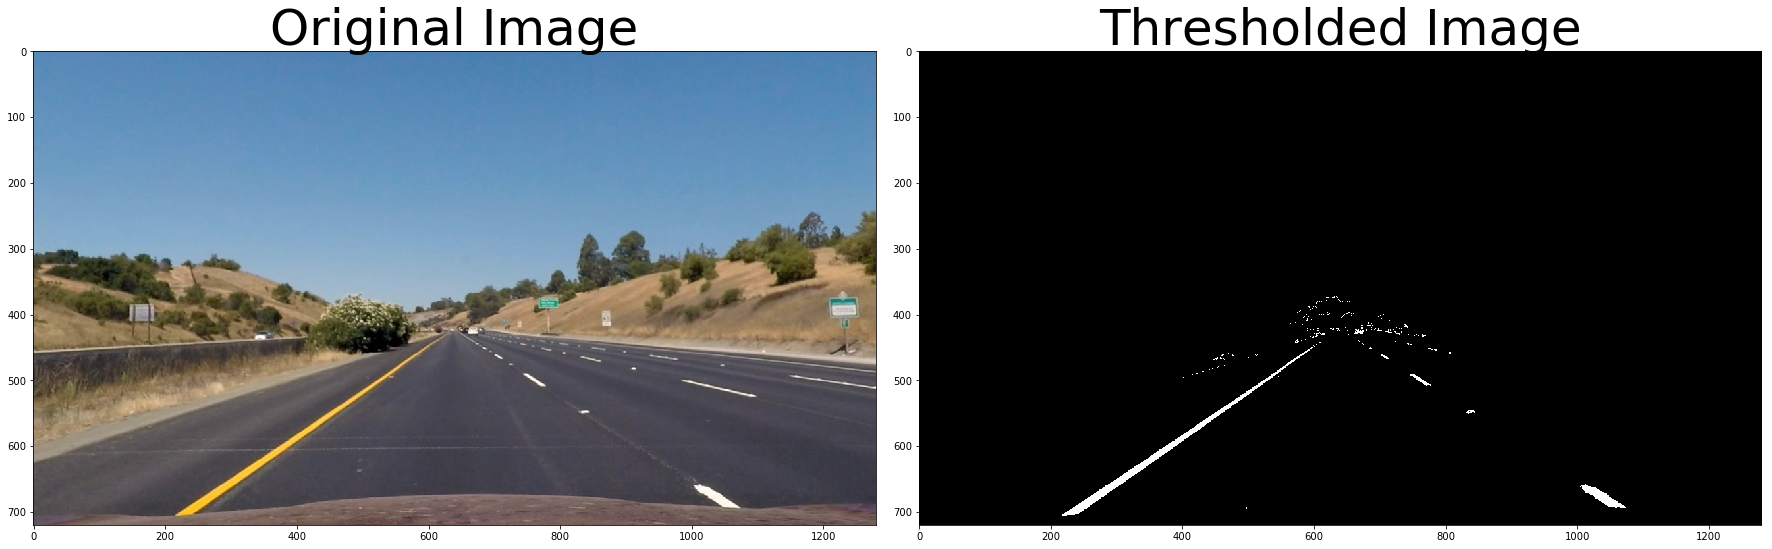

In [10]:
## Binary Threshold Image
img = cv2.cvtColor(cv2.imread('test_images/straight_lines1.jpg'),cv2.COLOR_BGR2RGB)
thresholded = get_thresholded_image(img)
img = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('thresholded.jpg',thresholded)

# Plot the 2 images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(thresholded, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

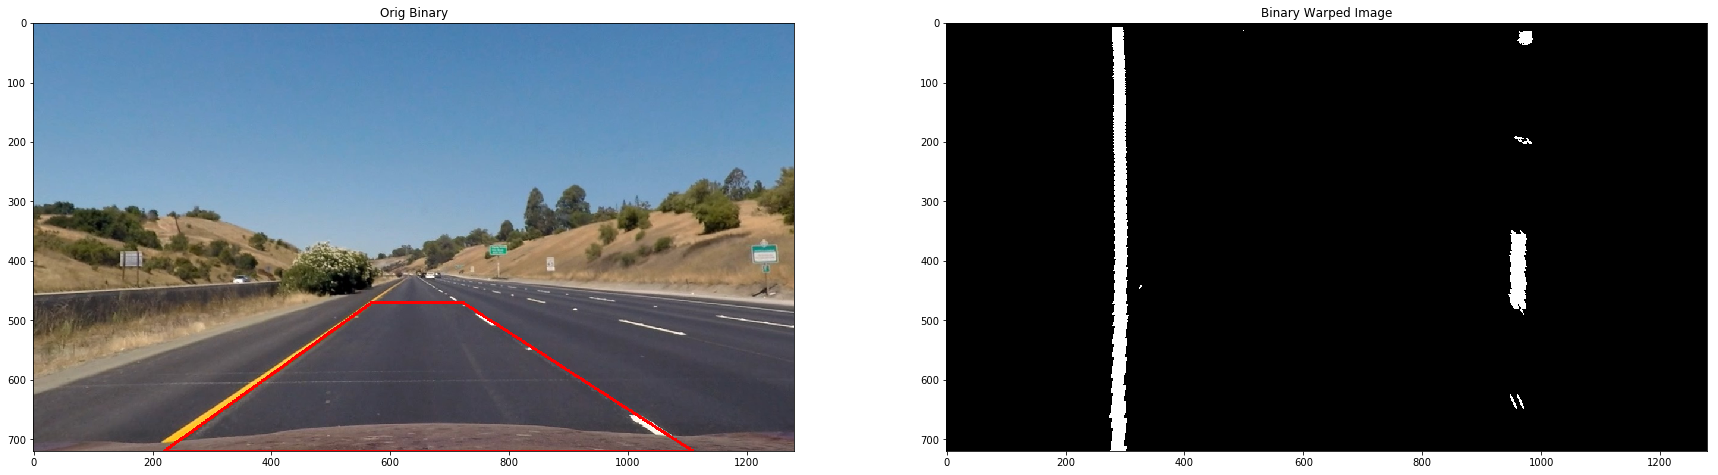

In [11]:
img_size = (thresholded.shape[1], thresholded.shape[0])
width, height = img_size
offset = 300

bottom_left = [220,720]
bottom_right = [1110, 720]
top_left = [570, 470]
top_right = [722, 470]

src = np.float32([
    bottom_left,
    bottom_right,
    top_right,
    top_left])


pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
pts = pts.reshape((-1,1,2))
copy = img.copy()
cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)

dst = np.float32([[offset, 0], [img_size[0] - offset, 0], [img_size[0] - offset, img_size[1]], [offset, img_size[1]]])
M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst, src)

plt.figure(figsize=(30,60))
plt.subplot(1,2,1)
plt.imshow(copy)
plt.title('Orig Binary')

plt.subplot(1,2,2)
binary_warped = cv2.warpPerspective(thresholded,M, (width, height))
plt.imshow(binary_warped, cmap='gray')
plt.title('Binary Warped Image')

286 968


//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


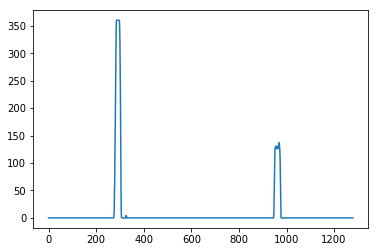

In [12]:
## Lane Detection

##Histogram
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)

# Peak in the first half indicates the likely position of the left lane
half_width = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:half_width])

# Peak in the second half indicates the likely position of the right lane
rightx_base = np.argmax(histogram[half_width:]) + half_width

print(leftx_base, rightx_base)
plt.plot(histogram)

In [13]:
def fitlines(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
   
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit =[]
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit =[]
    else:
        right_fit = np.polyfit(righty, rightx, 2)
    

    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


    return left_fit, right_fit,out_img

//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(720, 1280, 3)
255


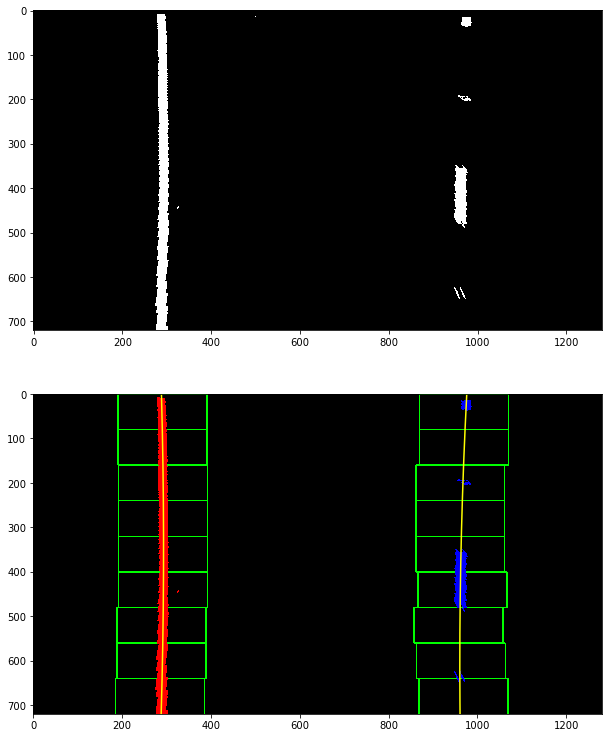

In [18]:
left_fit, right_fit,out_img = fitlines(binary_warped)


print(out_img.shape)
print(np.max(out_img))


ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    

plt.figure(figsize=(30,20))
plt.subplot(3,1,1)
plt.imshow(binary_warped, cmap='gray')

plt.subplot(3,1,2)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.subplot(3,1,2)


In [36]:
def fit_continuous(left_fit, right_fit, binary_warped):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit_updated =[]
    else:
        left_fit_updated = np.polyfit(lefty, leftx, 2)
    
    
    if len(rightx) == 0:
        right_fit_updated =[]
    else:
        right_fit_updated = np.polyfit(righty, rightx, 2)
        
    return  left_fit_updated, right_fit_updated


#Calc Curvature
def curvature(left_fit, right_fit, binary_warped):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension


    # Fit new polynomials to x,y in world space
    #leftx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    #rightx = right_fit[0]*ploty**2+right_fit[1]*ploty+left_fit[2]
        
    #left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    #right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    center = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 640)*xm_per_pix
    
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad, right_curverad, center

#Draw line and return image

def drawLine(undist, warped,left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    #print(left_fitx)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))


    #print(np.int_(pts))


    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (255,215, 0))

    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 

    # Combine the result with the original image
    
    #print("undist", undist.shape)
    #print("newwarp", newwarp.shape)
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #result = cv2.addWeighted(undist, 0, newwarp, 1, 0)
    return(result, color_warp)

In [20]:
def sanity_check(left_fit, right_fit, minSlope, maxSlope):
    #Performs a sanity check on the lanes
    #Check 1: check if left and right fits exists
    #Check 2: Calculates the tangent between left and right in two points, and check if it is in a reasonable threshold
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False
        d0=0
        d1=0
        #Previous fitlines routine returns empty list to them if not finds
    else:
        #Difference of slope
        L_0 = 2*left_fit[0]*460+left_fit[1]
        R_0 = 2*right_fit[0]*460+right_fit[1]
        d0 =  np.abs(L_0-R_0)

        L_1 = 2*left_fit[0]*720+left_fit[1]
        R_1 = 2*right_fit[0]*720+right_fit[1]
        d1 =  np.abs(L_1-R_1)

        
        if d0>= minSlope and d0<= maxSlope and d1>= minSlope and d1<= maxSlope:
            status = True
        else:
            status = False
            
    return(status, d0, d1)

In [54]:
#Function to process the image
global counter
counter=0
ref_left =np.array([-0.0001,0,400])
ref_right=np.array([-0.0001,0,1000])   
left_fit =np.array([-0.0001,0,400])
right_fit=np.array([-0.0001,0,1000])   



def process_image(image):
    #1. Camera correction
    #Calibration arrays pre-calculated
    #img_undist = cv2.undistort(image, mtx, dist, None, mtx)
    img_undist = cv2.undistort(image, mtx, dist, None, mtx)
    global counter
    
    #2.Magnitude Threshold
    #Threshold color    
    ##yellow_low = np.array([0,100,100])
    #yellow_high = np.array([50,255,255])
    #white_low = np.array([18,0,180])
    #white_high = np.array([255,80,255])
    thresholded = get_thresholded_image(img_undist)
    global ref_left 
    global ref_right
    global left_fit
    global right_fit

    #imgThres_yellow = hls_color_thresh(img_undist,yellow_low,yellow_high)
    #imgThres_white = hls_color_thresh(img_undist,white_low,white_high)
    #imgThr_sobelx = sobel_x(img_undist,9,80,220) #Sobel x

    #img_mag_thr =np.zeros_like(imgThres_yellow)
    #imgThresColor[(imgThres_yellow==1) | (imgThres_white==1)] =1
    #img_mag_thr[(imgThres_yellow==1) | (imgThres_white==1) | (imgThr_sobelx==1)] =1
        
    #3. Birds-eye
    #Perspective array pre-calculated
    img_size = (thresholded.shape[1], thresholded.shape[0])
    binary_warped = cv2.warpPerspective(thresholded, M, img_size, flags=cv2.INTER_LINEAR)
    
    #4. Detect lanes and return fit curves
    
    if counter==0:
        left_fit, right_fit,out_imgfit = fitlines(binary_warped)
    else:
        left_fit, right_fit = fit_continuous(left_fit, right_fit, binary_warped)
    
    
    #Project video (2.8, 3.5)
    status_sanity, d0, d1 =sanity_check(left_fit, right_fit, 0, .55)
    #Challenge video (2.4,3.1)
    #status_sanity, d0, d1, d2 =sanity_check(left_fit, right_fit, 2.4,3.1)
    
    #print(left_fit)
    #print(right_fit)
    
    #Calc curvature and center
    if status_sanity  == True:        
        #Save as last reliable fit
        ref_left, ref_right = left_fit, right_fit        
        counter+=1
    else:        #Use the last realible fit
        left_fit, right_fit = ref_left, ref_right
        
    left_curv, right_curv, center_off = curvature(left_fit, right_fit, binary_warped)

    #Warp back to original and merge with image    
    img_out, img_birds = drawLine(img_undist, binary_warped,left_fit, right_fit)
  
    #Write curvature and center in image
    TextL = "Left curv: " + str(int(left_curv)) + " m"
    TextR = "Right curv: " + str(int(right_curv))+ " m"
    TextC = "Center offset: " + str(round( center_off,2)) + "m"
    #TextAux = str(status_sanity) + ", d0: " + str(round(d0,2)) + ", d1: " + str(round(d1,2))
    fontScale=1
    thickness=2
    
    fontFace = cv2.FONT_HERSHEY_SIMPLEX


    cv2.putText(img_out, TextL, (130,40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextR, (130,70), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextC, (130,100), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
 
    return img_out

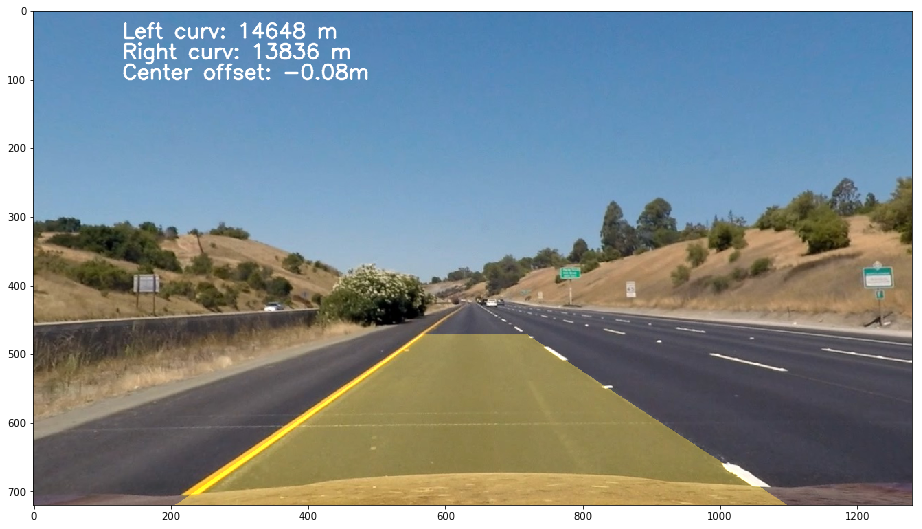

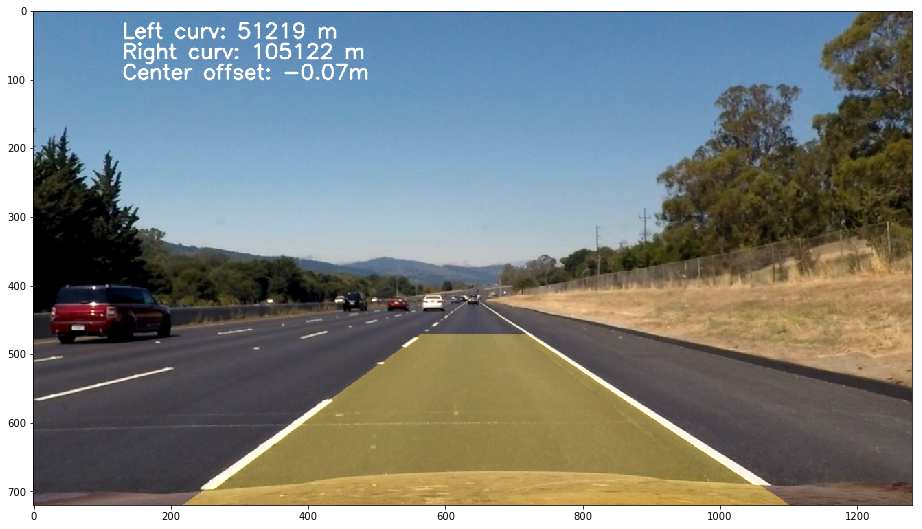

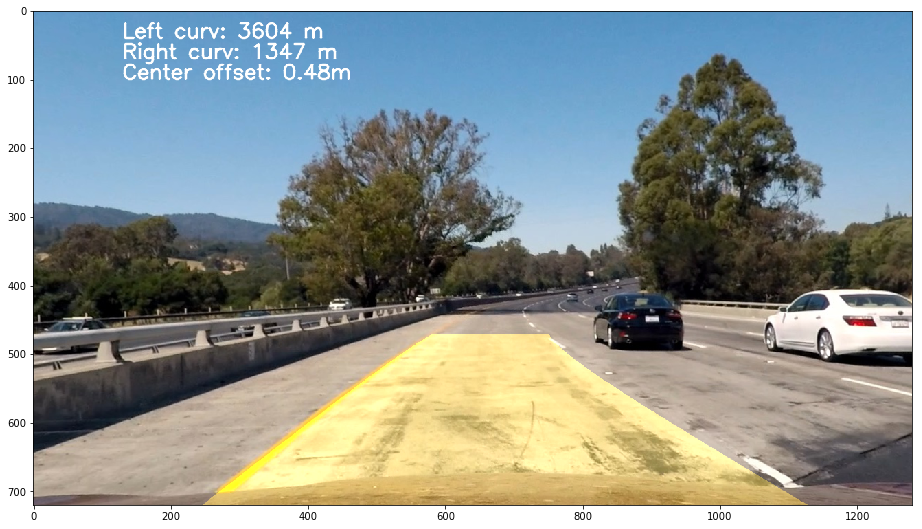

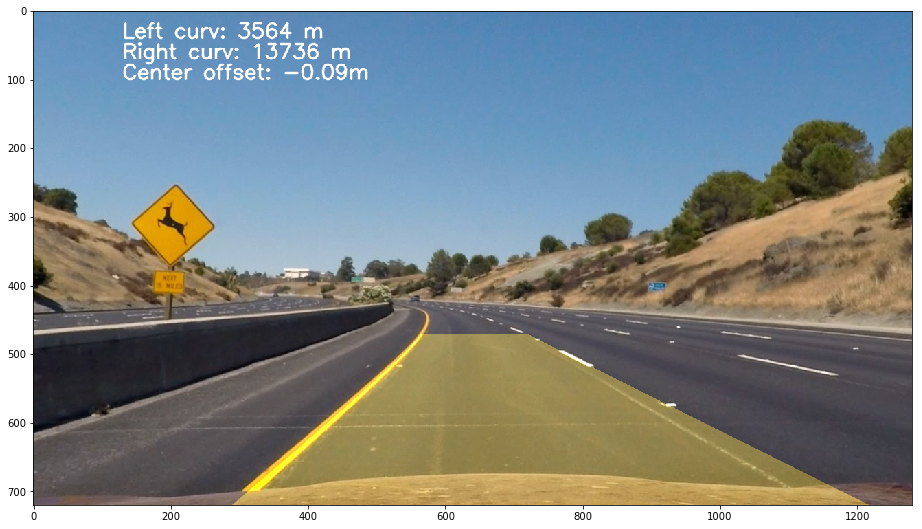

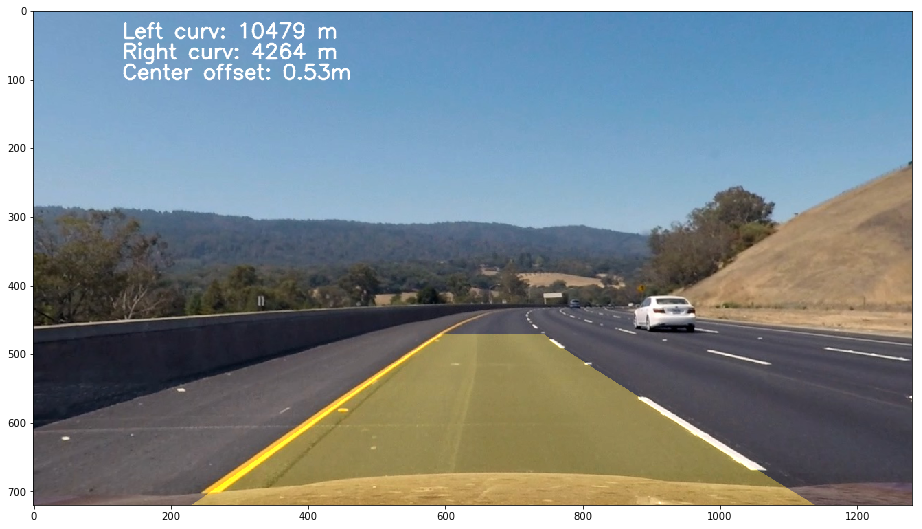

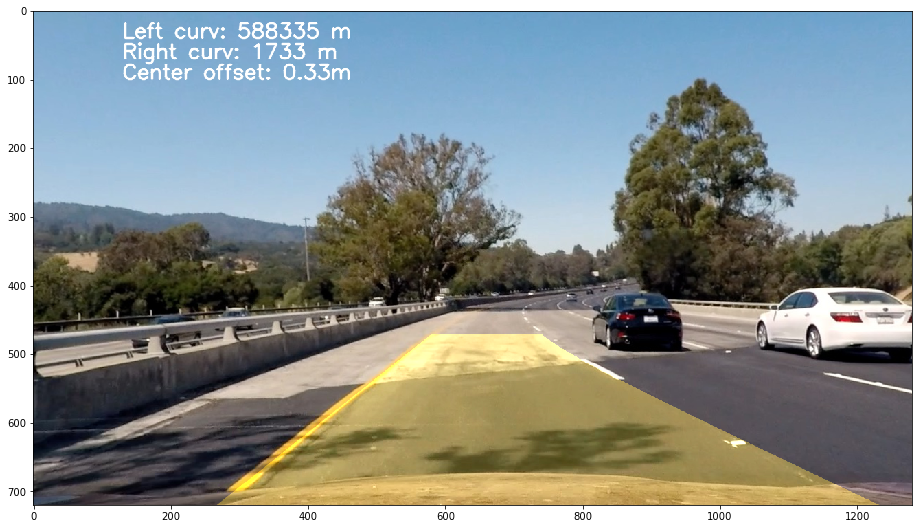

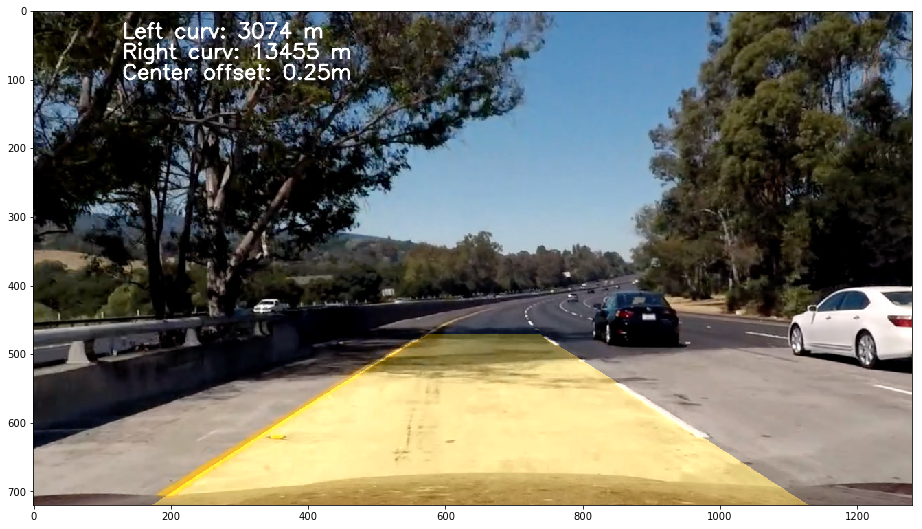

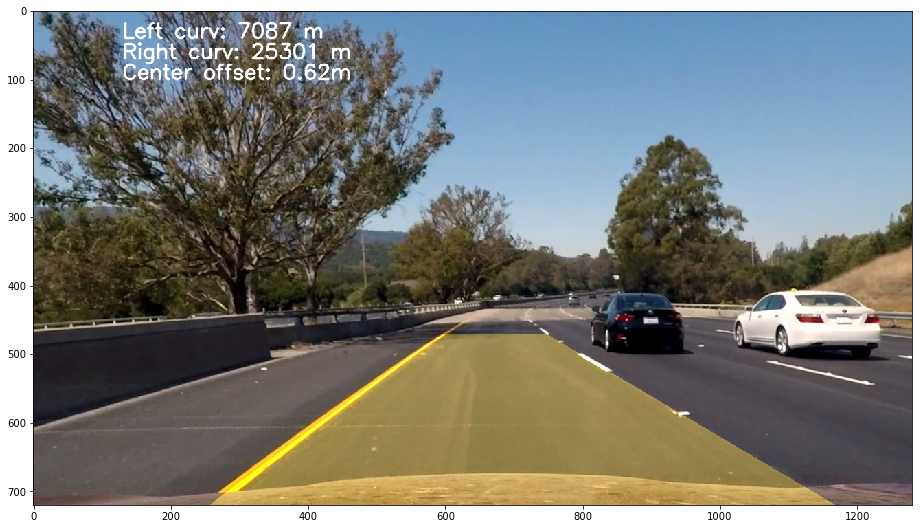

In [55]:
images = glob.glob('test_images/*.jpg')

for img in images:
    img = cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10,15))
#plt.figure(figsize=(5,10))
    img2= process_image(img)
  
    plt.figure(figsize=(30,20))
    plt.subplot(2,1,1)
    plt.imshow(img2)

In [56]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve


#Create video file pipeline
counter=0
output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(22,25)
#clip1 = VideoFileClip("challenge_video.mp4")
#clip1 = VideoFileClip("challenge_video.mp4")

out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)
print(counter)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4



100%|█████████▉| 1260/1261 [14:00<00:00,  1.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 18min 1s, sys: 1min 3s, total: 19min 5s
Wall time: 14min 3s
1259
